In [1]:
import pandas as pd
import numpy as np
from ete3 import Tree
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from pandas.api.types import is_numeric_dtype
import seaborn as sns
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import os

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
do_weighted = True
trans_method = "delta"
null_method = "patefield"

base_relevant_features = ["weighted NODF", # nestedness measures
                          "NODF",
                         "weighted connectance",
                         "connectance",
                         "modularity",
                         "robustness.LL"] # modularity mesure, when there is only one compartment, the divsrity is nan
relevant_features = base_relevant_features+[f"null_standardized_{f}" for f in base_relevant_features]
relevant_metadata = ['is_polyploid_poly_frac', 'is_polyploid_missing_frac']
                          
network_polyploid_data_path = "../../../data/ploidy_classification/network_classification.csv"
taxonomic_data_path = "../../../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
networks_metadata_path = "../../../data/networks/networks_metadata.csv"
plant_metadata_path = "../../../data/S2.csv"
ecoregions_metadata_path = "../../../data/metadata/network_level/ecoregions_metadata_rice_2019.xlsx"
ecoregions_polyfreq_path = "../../../data/metadata/network_level/ecoregions_polyfreq_rice_2019.xlsx"

allmb_tree_path = "../../../data/trees/families_mrca_based_tree.nwk"
networks_dir = "../../../data/networks/all/"

features_paths = {"binary": f"../../../data/features/network/binary/features_with_classification_{trans_method}_standardized_with_{null_method}_simulations.csv",
                  "binarized_weighted": f"../../../data/features/network/binarized_weighted/features_with_classification_{trans_method}_standardized_with_{null_method}_simulations.csv",
                  "weighted": f"../../../data/features/network/weighted/features_with_classification_{trans_method}_standardized_with_{null_method}_simulations.csv"}

processed_data_path = f"../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks_{trans_method}_standardized_with_{null_method}_simulations.csv"

max_missing_threshold = 0.5
min_classified_threshold = 6
min_poly_threhold = 0
min_di_threshold = 0
min_plants = 6
min_pollinators = 6

# form processed dataset

In [27]:
networks_metadata = pd.read_csv(networks_metadata_path)
networks_metadata["included_in_analysis"] = networks_metadata.apply(lambda rec: rec.is_polyploid_missing_frac <= max_missing_threshold and 
                                                              rec.num_classified >= min_classified_threshold and 
                                                              rec.num_polyploids >= min_poly_threhold and 
                                                              rec.num_diploids >= min_di_threshold and
                                                              rec.num_plants >= min_plants and
                                                              rec.num_pollinators >= min_pollinators, axis=1)


networks_metadata = networks_metadata.loc[networks_metadata.included_in_analysis].dropna(subset=['AnnualMeanTemperature', 'AnnualPrecipitation',
                'TemperatureSeasonality',"PrecipitationSeasonality",
                'MeanTemperatureofWarmestQuarter','PrecipitationofWarmestQuarter', "Isothermality",
                'frac_herb','frac_flw_rest','frac_sc',"network_size"])
# networks_metadata = networks_metadata.loc[networks_metadata.network_type != "weighted"]
print(f"# networks included in analysis = {networks_metadata.shape[0]:,}")
networks_metadata.groupby("network_type").network_index.count()

# networks included in analysis = 775


network_type
binarized_weighted    364
binary                 47
weighted              364
Name: network_index, dtype: int64

In [28]:
relevant_columns = ["network_index"] + relevant_features + relevant_metadata
weighted_data = pd.DataFrame()
if os.path.exists(features_paths["weighted"]):
    weighted_data = pd.read_csv(features_paths["weighted"])[relevant_columns]
    if not is_numeric_dtype(weighted_data.network_index):
        weighted_data['network_index'] = weighted_data.network.str.replace(".csv","").astype("int")
    weighted_data["network_type"] = "weighted"

binarized_weighted_data = pd.read_csv(features_paths["binarized_weighted"])[relevant_columns]
if not is_numeric_dtype(binarized_weighted_data.network_index):
    binarized_weighted_data['network_index'] = binarized_weighted_data.network.str.replace(".csv","").astype("int")
binarized_weighted_data["network_type"] = "binarized_weighted"

binary_data = pd.read_csv(features_paths["binary"])[relevant_columns]
if not is_numeric_dtype(binary_data.network_index):
    binary_data['network_index'] = binary_data.network.str.replace(".csv","").astype("int")
binary_data["network_type"] = "binary"  

features = pd.concat([weighted_data,binarized_weighted_data,binary_data]).rename(columns={"network_id": "network_index"})
features = features[[c for c in features.columns if not "Unnamed" in c]].drop_duplicates(["network_index", "network_type"])
features = features.dropna(subset=["is_polyploid_poly_frac"])
features = features.merge(networks_metadata[["network_type", "network_index", "plants_taxonomic_level", "path", "num_plants", "num_pollinators"]], on=["network_type", "network_index"], how="left")
features = features.loc[features.path.notna()] # remove duplicated networks

In [29]:
clean_features = features
clean_features.groupby("network_type")["network_index"].count()

network_type
binarized_weighted    355
binary                 45
weighted              346
Name: network_index, dtype: int64

In [30]:
if do_weighted:
    clean_features = clean_features.loc[clean_features.network_type == "weighted"]
else:
    clean_features = clean_features.loc[clean_features.network_type != "weighted"]
clean_features = clean_features.dropna()

In [31]:
print(f"# networks = {clean_features.shape[0]:,}")

# networks = 400


In [32]:
clean_features.notna().sum() / clean_features.shape[0]

network_index                             1.0
weighted NODF                             1.0
NODF                                      1.0
weighted connectance                      1.0
connectance                               1.0
modularity                                1.0
robustness.LL                             1.0
null_standardized_weighted NODF           1.0
null_standardized_NODF                    1.0
null_standardized_weighted connectance    1.0
null_standardized_connectance             1.0
null_standardized_modularity              1.0
null_standardized_robustness.LL           1.0
is_polyploid_poly_frac                    1.0
is_polyploid_missing_frac                 1.0
network_type                              1.0
plants_taxonomic_level                    1.0
path                                      1.0
num_plants                                1.0
num_pollinators                           1.0
dtype: float64

# compute phylogenetic diversity on remaining networks

In [9]:
tree = Tree(allmb_tree_path, format=1)
for l in tree.get_leaves():
    l.name = l.name.replace("_", " ").lower()

In [94]:
def get_phylogenetic_diveristy(network_path: str) -> float:
    try:
        network = pd.read_csv(network_path)
        plants = network.Plant.str.lower().tolist()
        plants_in_tree = set(plants) & set(tree.get_leaf_names())
        max_tbl = np.sum([n.dist for n in tree.traverse()])
        network_tree = tree.copy()
        network_tree.prune(plants_in_tree)
        phylo_divesity = np.sum([n.dist for n in network_tree.traverse()]) / len(network_tree.get_leaves())
        return phylo_divesity
    except Exception as e:
        # print(f"network_path={network_path}, error={e}")
        return max_tbl

clean_features["pd"] = clean_features.parallel_apply(lambda rec: get_phylogenetic_diveristy(f"../../../data/networks/all/{rec.network_type}/{rec.network_index}.csv"), axis=1)

In [95]:
clean_features.network_id = clean_features.network_index.astype(str) + "_" + clean_features.network_type

/tmp/ipykernel_39028/1525001505.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  clean_features.network_id = clean_features.network_index.astype(str) + "_" + clean_features.network_type


<AxesSubplot: >

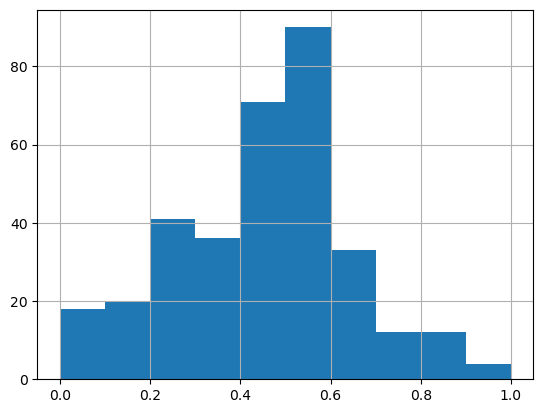

In [96]:
clean_features.is_polyploid_poly_frac.hist()

<AxesSubplot: >

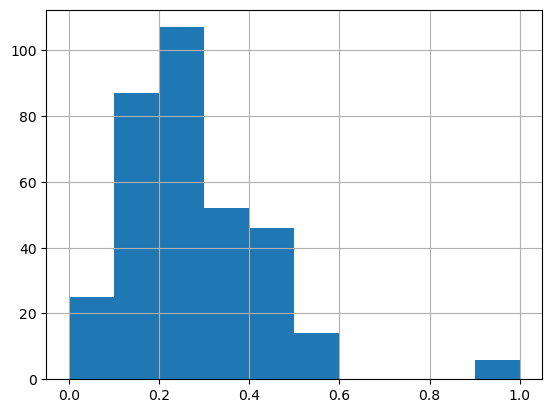

In [97]:
clean_features.is_polyploid_missing_frac.hist()

# save data

In [33]:
relevant_features = base_relevant_features + [f"null_standardized_{f}" for f in base_relevant_features]

In [34]:
clean_features = clean_features.drop_duplicates()
clean_features = clean_features.dropna(subset=relevant_features)
clean_features = clean_features.fillna(-1)
clean_features["has_polyploids"] = (clean_features.is_polyploid_poly_frac>0).astype(int)
print(f"# remaining records = {clean_features.shape[0]:,}")
clean_features.to_csv(processed_data_path)

# remaining records = 400


# devise plant-trait based features from plant trait data

In [35]:
plant_trait_cols = ['Growth_form', 'flw_shape_AST_head_level', 'n_flw_infl_AST_head_level','flw_symmetry_AST_head_level', 'mating_system']
plant_trait_data = pd.read_csv(plant_metadata_path)[["original_name"] + plant_trait_cols]   
plant_trait_data["is_herb"] = plant_trait_data.Growth_form.apply(lambda n: 1 if n == "herb" else (np.nan if pd.isna(n) else 0))
plant_trait_data["is_flw_rest"] = plant_trait_data.flw_shape_AST_head_level.apply(lambda n: 1 if n == "restrictive" else (np.nan if pd.isna(n) else 0))
plant_trait_data["is_multi_flw"] = plant_trait_data.n_flw_infl_AST_head_level.apply(lambda n: 1 if n == "multiple" else (np.nan if pd.isna(n) else 0))
plant_trait_data["is_symmetric"] = plant_trait_data.flw_symmetry_AST_head_level.apply(lambda n: 1 if n == "actinomorphic" else (np.nan if pd.isna(n) else 0))
plant_trait_data["is_sc"] = plant_trait_data.mating_system.apply(lambda n: np.nan if pd.isna(n) else (1 if "SC" in n else (np.nan if n=="unknown" else 0)))

In [36]:
def get_network_plants(network_path: str) -> list:
    try:
        net = pd.read_csv(network_path)
        if "Plant" not in net.columns:
            net = net.rename(columns={"Unnamed: 0": "Plant"})
        return net.Plant.str.lower().tolist()
    except Exception as e:
        print(network_path, e)
        return np.nan

def get_fracs_trait(plant_names: list, trait_dict: dict) -> list:
    plant_vals = np.array([trait_dict.get(p, np.nan) for p in plant_names])
    frac_ones = np.nansum(plant_vals) / sum(~np.isnan(plant_vals))
    frac_missing = sum(np.isnan(plant_vals))/len(plant_vals)
    return [frac_ones, frac_missing]
    
if "frac_flw_rest" not in networks_metadata.columns:
    networks_metadata["plants"] = networks_metadata.parallel_apply(lambda rec: get_network_plants(f"../../../data/networks/all/{rec.network_type}/{rec.network_index}.csv"), axis=1)
    for c in plant_trait_data.columns:
        if c.startswith("is_"):
            trait_dict = plant_trait_data.set_index("original_name")[c].to_dict()
            networks_metadata[[c.replace("is_", "frac_"), c.replace("is_", "frac_missing_")]] = networks_metadata.apply(lambda rec: get_fracs_trait(rec.plants, trait_dict=trait_dict), axis=1, result_type="expand")
            
networks_metadata["has_polyploids"] = (networks_metadata.is_polyploid_poly_frac > 0).astype(int)
if "plants" in networks_metadata.columns:
    networks_metadata.drop(["plants"], axis=1, inplace=True)

# merge with network metadata

In [37]:
clean_features = pd.read_csv(processed_data_path)
clean_features = clean_features[[c for c in clean_features.columns if not "Unnamed" in c]]

In [38]:
clean_features = clean_features.merge(networks_metadata, on=["network_type", "network_index"], how="left")
clean_features = clean_features.rename(columns={c: c.replace("_y","") for c in clean_features.columns if c.endswith("_y")}).drop([c for c in clean_features.columns if c.endswith("_x")], axis=1)
clean_features.to_csv(processed_data_path, index=False)

# rename columns

In [39]:
df = pd.read_csv(processed_data_path)
df = df.rename(columns={"is_polyploid_poly_frac": "FracPolyploids",
                        'frac_herb':"FracHerb",
                        'frac_flw_rest': "FracRestrictive",
                        'frac_sc': "FracSelfers",
                        "is_polyploid_missing_frac": "FracMissingPloidyClassifications",
                        "null_standardized_connectance": "Connectance",
                        "null_standardized_weighted connectance": "Weighted Connectance",
                        "null_standardized_NODF": "Nestedness",
                        "null_standardized_weighted NODF": "Weighted Nestedness",
                        "null_standardized_modularity": "Modularity",
                        "null_standardized_robustness.LL": "Robustness",
                        "polyploidPercent": "FracPolyploidsInEcoregion",
                        "BIO1": "AnnualMeanTemperature", 
                        "BIO2": "AnnualPrecipitation",
                        "BIO15": "PrecipitationSeasonality",
                        "BIO18": "PrecipitationofWarmestQuarter",
                        "BIO10": "MeanTemperatureofWarmestQuarter",
                        "BIO4": "TemperatureSeasonality"})
                        # "AnnualMeanTemperature": "BIO1", 
                        # "AnnualPrecipitation": "BIO2",
                        # "PrecipitationSeasonality": "BIO15",
                        # "PrecipitationofWarmestQuarter": "BIO18",
                        # "MeanTemperatureofWarmestQuarter": "BIO10",
                        # "TemperatureSeasonality": "BIO4"})
if df.FracPolyploidsInEcoregion.max() > 1:
    df.FracPolyploidsInEcoregion = df.FracPolyploidsInEcoregion / 100
df.to_csv(processed_data_path, index=False)

## debug - comprate % polyploids within netwrosk to % polyploids within their respective ecoregions to assess variational effect across networks

### % polyploids

/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 1.0, '# Ecoregions = 28, Pearson correlation = -0.001')

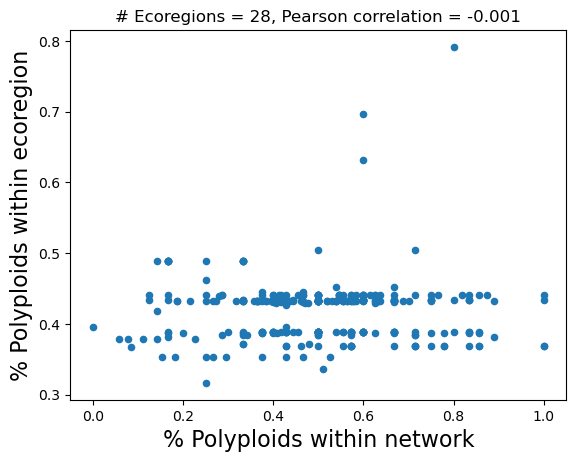

In [16]:
clean_features = pd.read_csv(processed_data_path)
fig, ax = plt.subplots(1,1)
debug = clean_features.loc[clean_features.included_in_analysis == 1].dropna(subset=["FracPolyploids", "FracPolyploidsInEcoregion"])
debug.plot.scatter(x="FracPolyploids", y="FracPolyploidsInEcoregion", ax=ax)
ax.set_ylabel("% Polyploids within ecoregion", fontsize=16)
ax.set_xlabel("% Polyploids within network", fontsize=16)
ax.set_title(f"# Ecoregions = {len(debug.EcoRegion.unique()):,}, Pearson correlation = {np.round(np.corrcoef(debug.FracPolyploids, debug.FracPolyploidsInEcoregion)[0,1], 3)}")

In [66]:
ecoregion_ids_map_path = "../../../data/metadata/network_level/ecoregions.csv"
ecoregion_metadata_path_1 = "../../../data/metadata/network_level/ecoregions_metadata_rice_2019.xlsx"
ecoregion_metadata_path_2 = "../../../data/metadata/network_level/ecoregions_polyfreq_rice_2019.xlsx"

ecoregion_df = pd.read_csv(ecoregion_ids_map_path).drop_duplicates("eco_names", keep="first")
ecoregion_df.eco_names = ecoregion_df.eco_names.str.lower() 
eco_id_to_name = ecoregion_df.set_index("eco_ids")["eco_names"].to_dict()
eco_name_to_id = ecoregion_df.set_index("eco_names")["eco_ids"].to_dict()

ecoregion_metadata_1 = pd.read_excel(ecoregion_metadata_path_1, header=6)
ecoregion_metadata_1["ECO_NAME"] = ecoregion_metadata_1['ECO ID'].apply(lambda n: eco_id_to_name.get(n, np.nan))
# ecoregion_metadata_1.set_index("ECO name", inplace=True)

ecoregion_metadata_2 = pd.read_excel(ecoregion_metadata_path_2, header=1)
ecoregion_metadata_2["Ecoregion name"] = ecoregion_metadata_2["Ecoregion name"].str.lower() 

ecoregion_metadata_2.set_index("Ecoregion name", inplace=True)

In [67]:
ecoregion_metadata_1["Classified"] = ecoregion_metadata_1.Diploids + ecoregion_metadata_1.Polyploids
ecoregion_metadata_1.loc[ecoregion_metadata_1.ECO_NAME.isin(["california central valley grasslands", "taiheiyo montane deciduous forests",
                                                             "colorado plateau shrublands", "high arctic tundra", "humid pampas"])][["ECO_NAME", "Species","Classified", "Diploids","Polyploids","Polyploid percent"]]

,ECO_NAME,Species,Classified,Diploids,Polyploids,Polyploid percent
229,california central valley grasslands,1384.0,780.0,492.0,288.0,36.923077
250,high arctic tundra,110.0,72.0,15.0,57.0,79.166667
264,colorado plateau shrublands,1182.0,607.0,371.0,236.0,38.879736
386,humid pampas,448.0,236.0,116.0,120.0,50.847458
455,taiheiyo montane deciduous forests,1460.0,865.0,535.0,330.0,38.150289


In [70]:
debug["frac_diff"] = abs(debug.FracPolyploids-debug.FracPolyploidsInEcoregion)
debug = debug.loc[debug.frac_diff > 0.2]
debug[["EcoRegion_name", "num_plants", "num_classified", "FracPolyploids", "FracPolyploidsInEcoregion", "frac_diff"]].sort_values(["EcoRegion_name", "frac_diff"], ascending=[True, False]).head(n=11)

,EcoRegion_name,num_plants,num_classified,FracPolyploids,FracPolyploidsInEcoregion,frac_diff
71,Central U.S. hardwood forests,10,8,0.000000,0.377919,0.377919
75,Central U.S. hardwood forests,11,6,0.000000,0.377919,0.377919
278,Central U.S. hardwood forests,9,6,0.000000,0.377919,0.377919
93,Central U.S. hardwood forests,21,17,0.058824,0.377919,0.319096
67,Central U.S. hardwood forests,12,7,0.142857,0.377919,0.235062
299,Central forest-grasslands transition,8,5,0.800000,0.383861,0.416139
68,Central forest-grasslands transition,14,10,0.600000,0.383861,0.216139
94,Colorado Rockies forests,8,5,1.000000,0.388797,0.611203
97,Colorado Rockies forests,11,8,0.750000,0.388797,0.361203
25,Colorado Rockies forests,7,6,0.666667,0.388797,0.277869


In [71]:
metadata_cols = set(clean_features.columns)-set(networks_metadata.columns) - {'network_id',
                                                                              'weighted NODF','weighted connectance', 'modularity',
                                                                              'null_standardized_weighted NODF','null_standardized_weighted connectance','null_standardized_modularity'}
if len(metadata_cols) > 0:
    networks_metadata = networks_metadata.merge(clean_features[["EcoRegion_name"] + list(metadata_cols)], on="EcoRegion_name", how="left")

In [72]:
clean_features.to_csv(processed_data_path, index=False)

In [73]:
clean_features["path"] = clean_features.apply(lambda rec: networks_metadata.loc[(networks_metadata.network_index == rec.network_index) & (networks_metadata.network_type == rec.network_type)].path.values[0], axis=1)

In [74]:
clean_features.filter(like="missing")

,frac_missing_flw_rest,frac_missing_herb,frac_missing_multi_flw,frac_missing_sc,frac_missing_symmetric
0,0.375000,0.375000,0.375000,0.625000,0.375000
1,0.333333,0.333333,0.333333,0.333333,0.333333
2,0.181818,0.181818,0.181818,0.454545,0.272727
3,0.142857,0.142857,0.142857,0.714286,0.142857
4,0.166667,0.166667,0.166667,0.666667,0.166667
...,...,...,...,...,...
327,0.240000,0.240000,0.240000,0.480000,0.240000
328,0.515625,0.515625,0.515625,0.921875,0.546875
329,0.428571,0.428571,0.428571,0.714286,0.428571
330,0.500000,0.500000,0.500000,0.718750,0.500000


# plot data

In [8]:
clean_features = pd.read_csv(processed_data_path)
clean_features = clean_features.loc[(clean_features.FracMissingPloidyClassifications <= max_missing_threshold) &
                                    (clean_features.num_classified >= min_classified_threshold) &
                                    (clean_features.num_polyploids >= min_poly_threhold) &
                                    (clean_features.num_diploids >= min_di_threshold) &
                                   (clean_features.num_pollinators >= min_pollinators)] 
print(f"# networks for analysis = {clean_features.shape[0]:,}")

# networks for analysis = 300


/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


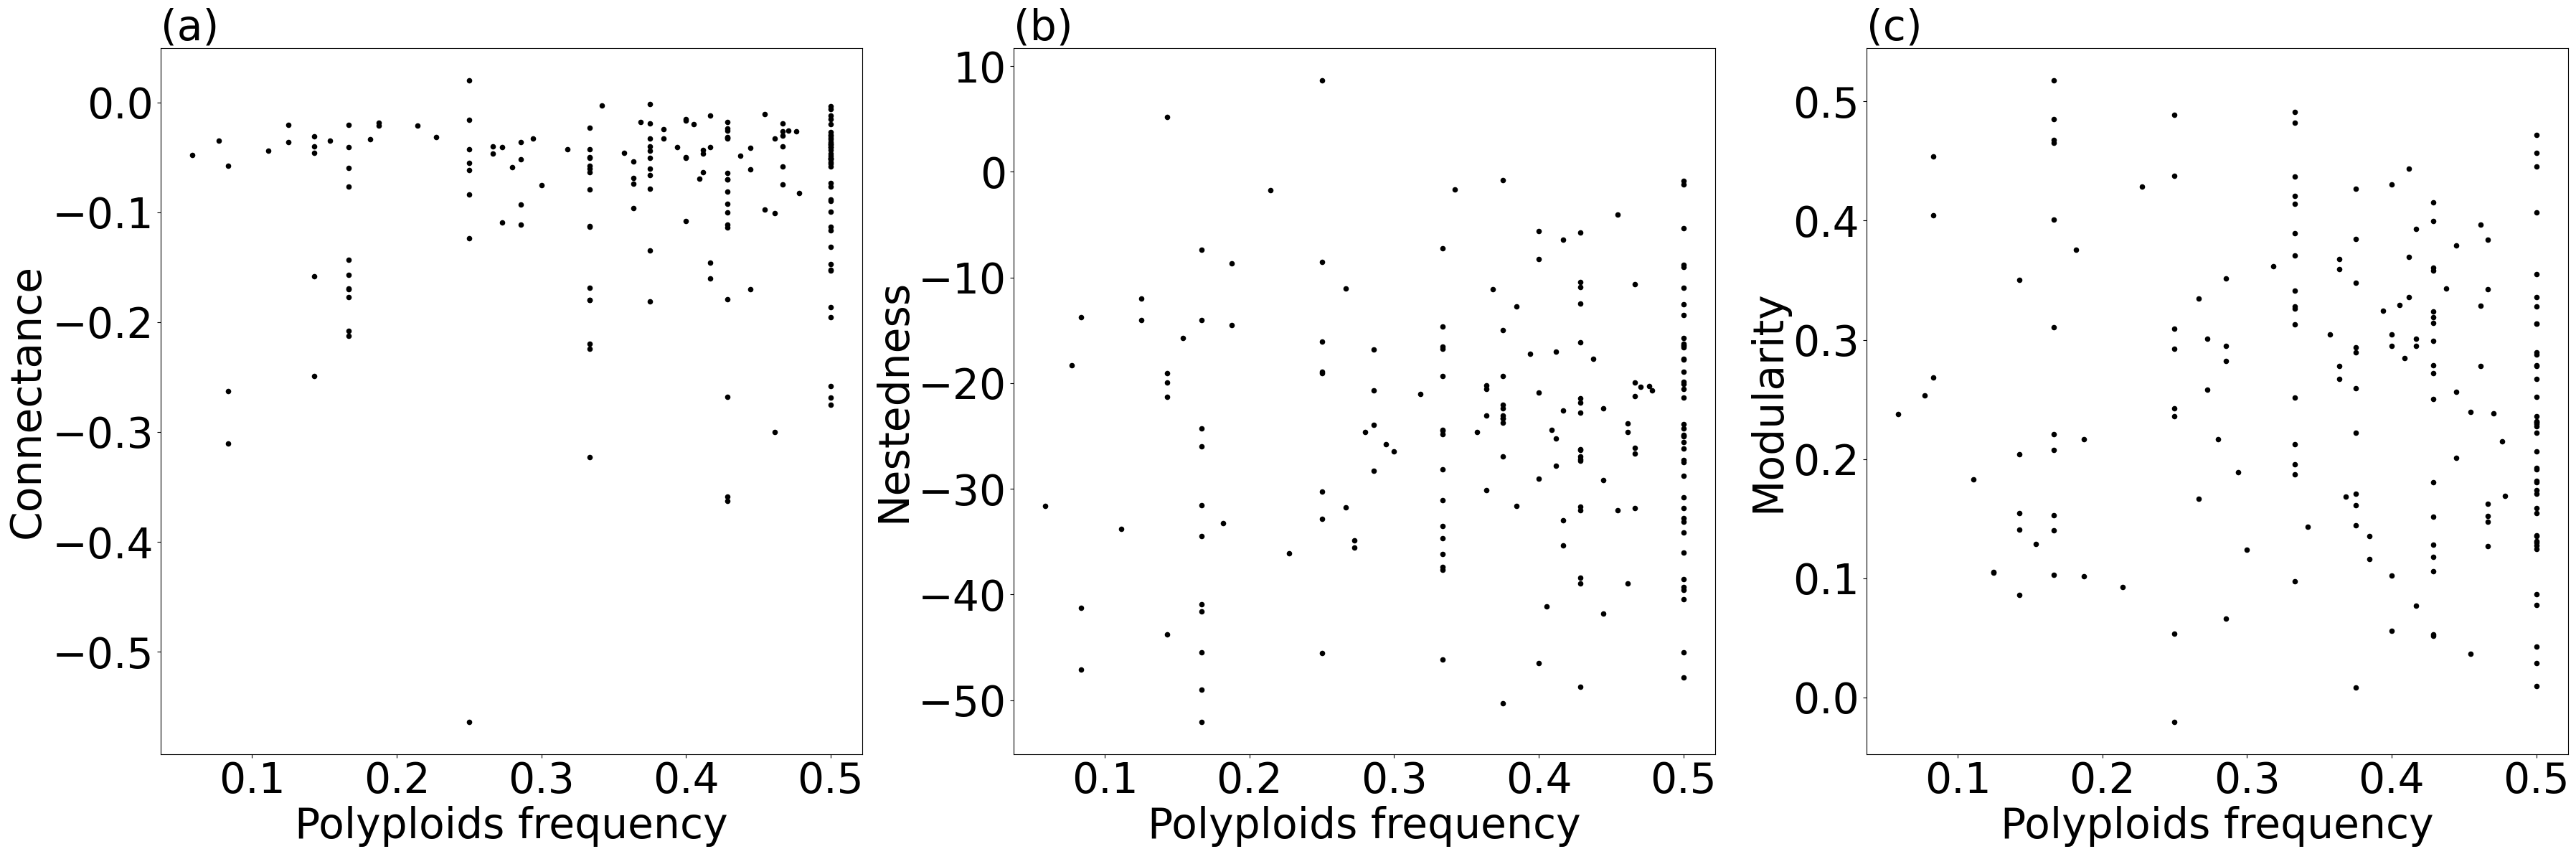

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42

plotting_features = clean_features#.loc[(clean_features.is_polyploid_missing_frac <= missing_data_threshold) & (clean_features.num_classified >= n_classified_threshold)]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*12, 1*12))
plotting_features = clean_features.loc[clean_features.FracPolyploids <= 0.5]

ax1 = ax[0]
ax1.set_title("(a)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="FracPolyploids", y="Connectance", ax=ax1, color="black")
ax1.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax1.set_ylabel("Connectance", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize)


ax2 = ax[1]
ax2.set_title("(b)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="FracPolyploids", y="Nestedness", ax=ax2, color="black")
ax2.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax2.set_ylabel("Nestedness", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize)


ax3 = ax[2]
ax3.set_title("(c)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="FracPolyploids", y="Modularity", ax=ax3, color="black")
ax3.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax3.set_ylabel("Modularity", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize)


fig.tight_layout()
fig.savefig(f"../../../data/figures/fig3_{'binary' if not do_weighted else 'weighted'}.jpeg")

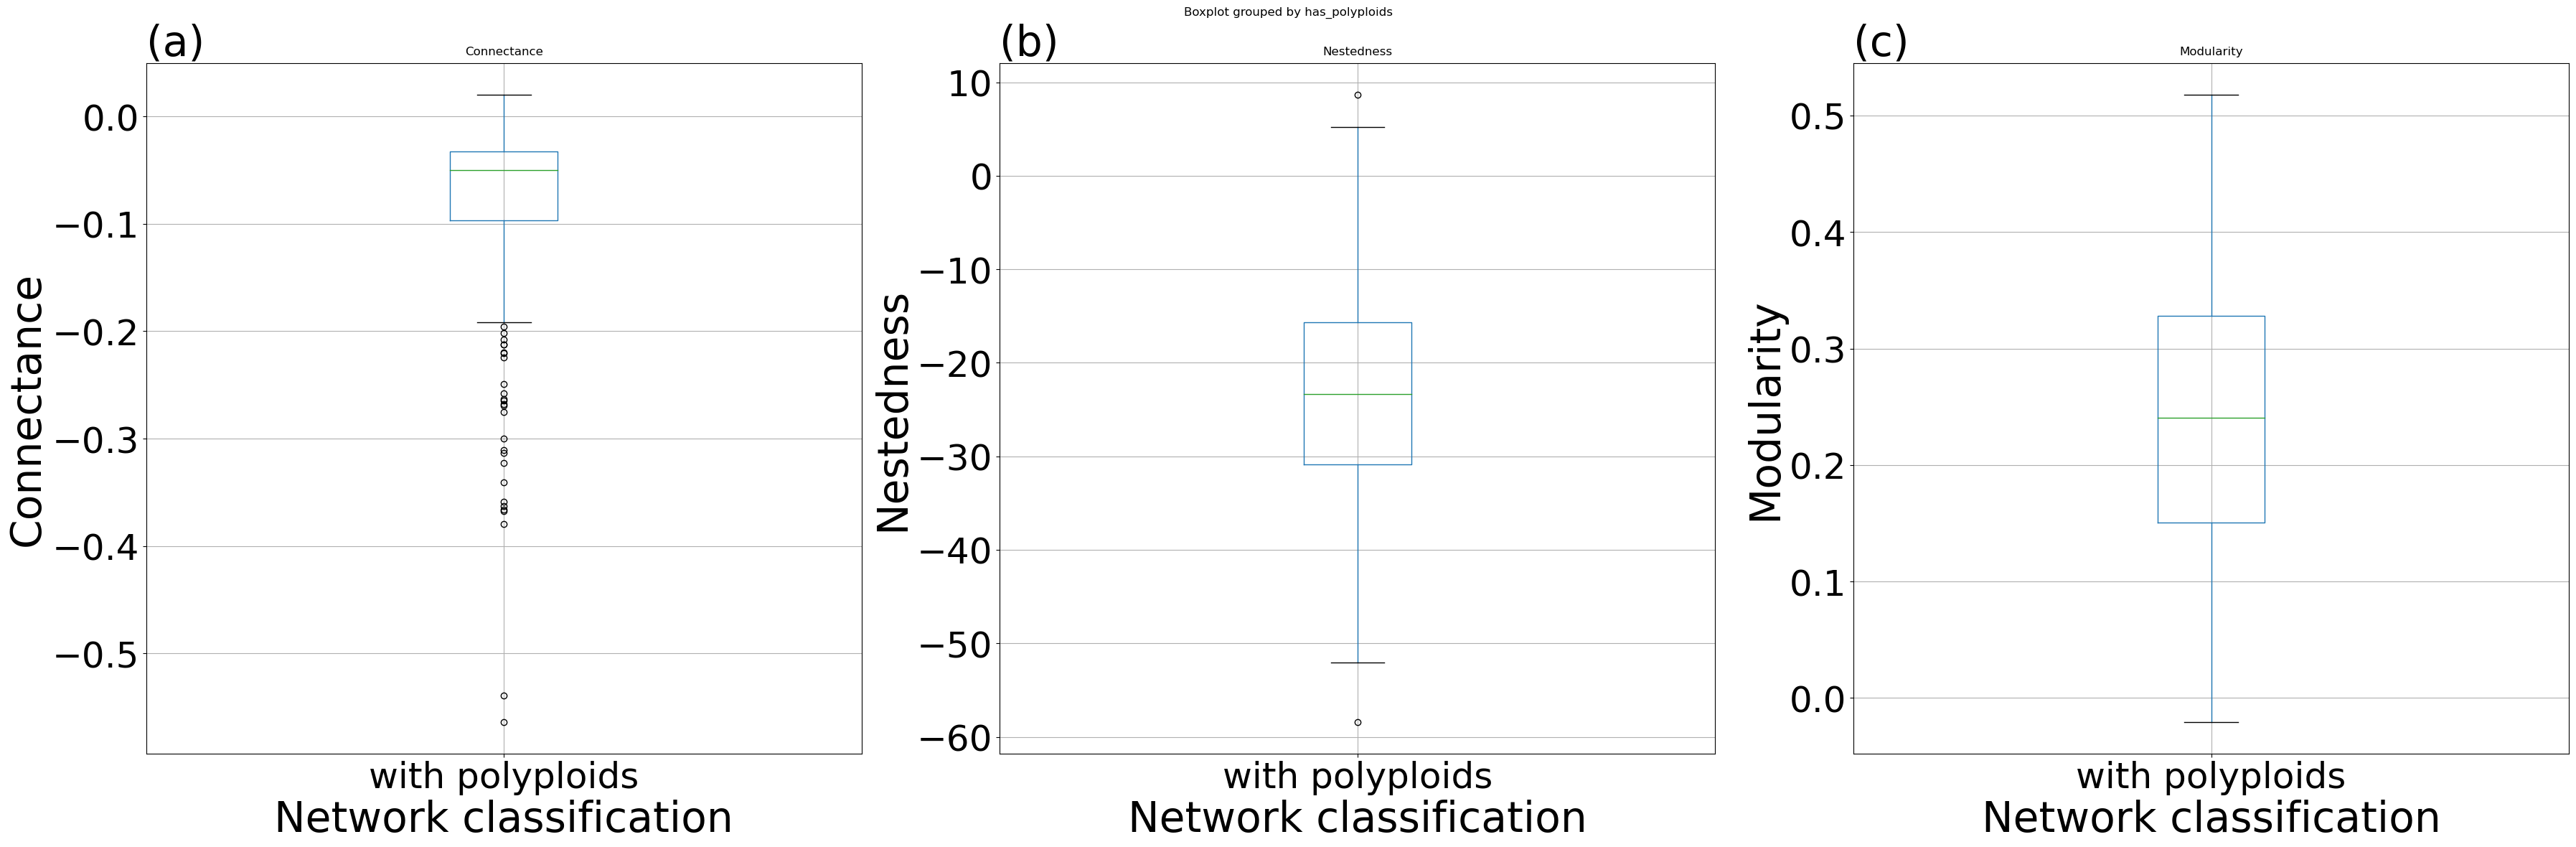

In [10]:
plotting_features = clean_features.copy()
plotting_features.has_polyploids = plotting_features.has_polyploids.replace({0: "without polyploids", 1: "with polyploids"}) 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*12, 1*12))

ax1 = ax[0]
ax1.set_title("(a)", loc="left", fontsize=fontsize)
plotting_features[["has_polyploids", "Connectance"]].boxplot(by="has_polyploids", ax=ax1)
ax1.set_ylabel("Connectance", fontsize=fontsize)
ax1.set_xlabel("Network classification",  fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize-6)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize-6)

ax2 = ax[1]
ax2.set_title("(b)", loc="left", fontsize=fontsize)
plotting_features[["has_polyploids", "Nestedness"]].boxplot(by="has_polyploids", ax=ax2)
ax2.set_ylabel("Nestedness", fontsize=fontsize)
ax2.set_xlabel("Network classification",  fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize-6)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize-6)

ax3 = ax[2]
ax3.set_title("(c)", loc="left", fontsize=fontsize)
plotting_features[["has_polyploids", "Modularity"]].boxplot(by="has_polyploids", ax=ax3)
ax3.set_ylabel("Modularity", fontsize=fontsize)
ax3.set_xlabel("Network classification",  fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize-6)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize-6)

fig.tight_layout()
fig.savefig(f"../../../data/figures/fig4_{'binary' if not do_weighted else 'weighted'}.jpeg")

In [12]:
from scipy import stats

conc_res = stats.kruskal(clean_features.loc[clean_features.has_polyploids == 0, "Connectance"].values, 
                         clean_features.loc[clean_features.has_polyploids == 1, "Connectance"].values)
print(f"Connectance = {conc_res}")

nest_res = stats.kruskal(clean_features.loc[clean_features.has_polyploids == 0, "Nestedness"].values, 
                         clean_features.loc[clean_features.has_polyploids == 1, "Nestedness"].values)
print(f"Nestedness = {nest_res}")

mod_res = stats.kruskal(clean_features.loc[clean_features.has_polyploids == 0, "Modularity"].values, 
                         clean_features.loc[clean_features.has_polyploids == 1, "Modularity"].values)
print(f"Modularity = {mod_res}")

Connectance = KruskalResult(statistic=nan, pvalue=nan)
Nestedness = KruskalResult(statistic=nan, pvalue=nan)
Modularity = KruskalResult(statistic=nan, pvalue=nan)


# plot for papers

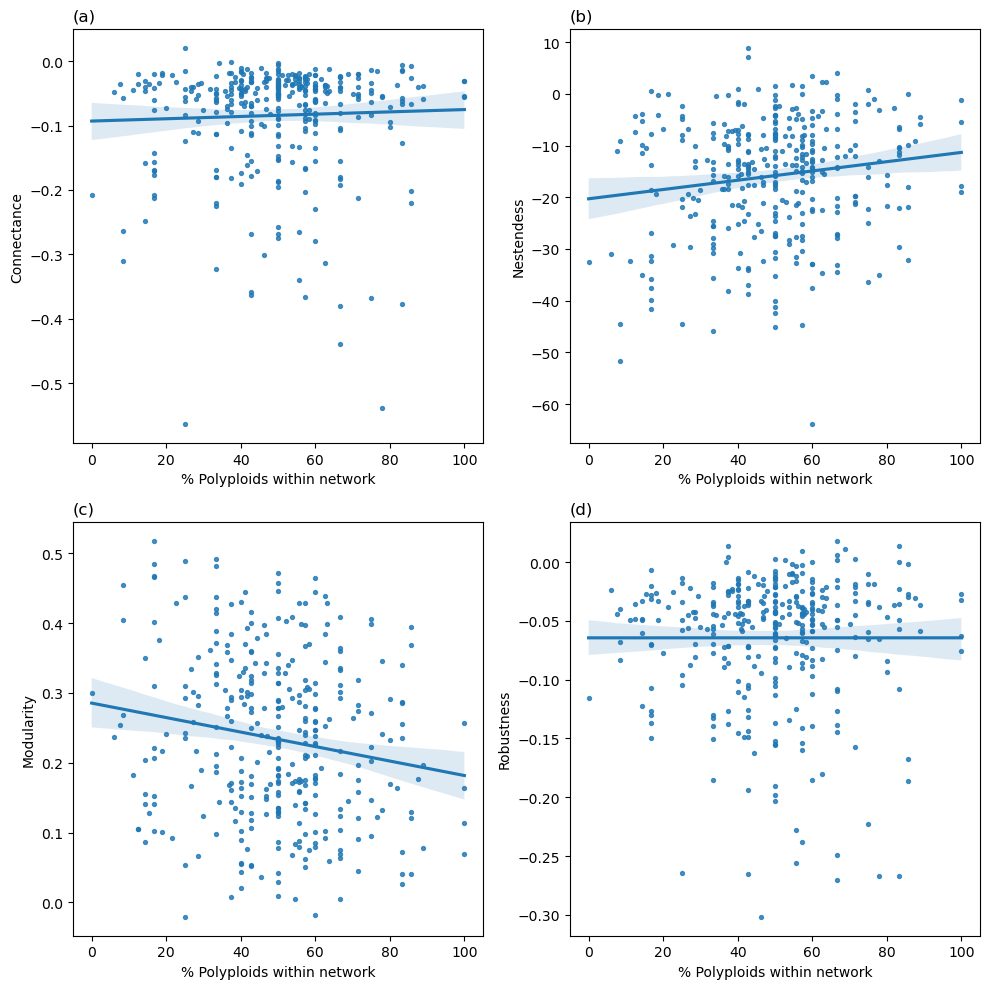

In [13]:
df = pd.read_csv(processed_data_path)
df["% Polyploids within network"] = df.FracPolyploids*100

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.regplot(x="% Polyploids within network", y='Connectance', data=df, scatter_kws={"s": 8}, ax=ax[0][0])
ax[0][0].set_title("(a)", loc='left')
sns.regplot(x="% Polyploids within network", y=f'{"Weighted " if do_weighted else ""}Nestedness', data=df, scatter_kws={"s": 8}, ax=ax[0][1])
ax[0][1].set_ylabel("Nestendess")
ax[0][1].set_title("(b)", loc='left')
sns.regplot(x="% Polyploids within network", y='Modularity', data=df, scatter_kws={"s": 8}, ax=ax[1][0])
ax[1][0].set_title("(c)", loc='left')
sns.regplot(x="% Polyploids within network", y='Robustness', data=df, scatter_kws={"s": 8}, ax=ax[1][1])
ax[1][1].set_title("(d)", loc='left')

fig.tight_layout()
fig.savefig(f"../../../data/figures/fig3_{'' if do_weighted else 'un'}weighted.svg")

In [23]:
# import matplotlib.pyplot as plt

# # Sample data (replace with your own data)
# # Create a scatterplot
# sns.scatterplot(df.FracPolyploids, df.FracRestrictive, c='blue', hue=df.Connectance, palette='viridis')

# # Customize the plot
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.title("Interaction between Two Continuous Variables")
# plt.legend()

# # Show the plot
# plt.show()